# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import helpers
from slam import get_residual, get_my_jacob, get_jax_jacob, calc_init_poses, LM


## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

Estimate using odometry


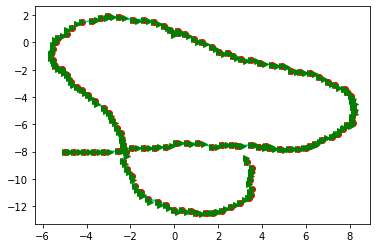

In [2]:

EDGES_FILE = '../data/edges.txt'
EDGES_POSES_FILE = '../data/edges-poses.g2o'

nodes, edges = helpers.read_data(EDGES_FILE)
fixed = nodes[:, 0]
poses = calc_init_poses(fixed, edges)
print("Estimate using odometry")
helpers.draw_one(poses[:, 0], poses[:, 1], poses[:, 2])
helpers.write_edges_poses(EDGES_POSES_FILE, EDGES_FILE, poses)


## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [3]:
def compare_jacobs():
    my_jacob = get_my_jacob(poses, edges, fixed)
    jax_jacob = get_jax_jacob(poses, edges, fixed)

    print("Comparing Jacobians")
    helpers.frobNorm(my_jacob, jax_jacob, "my jacobian", "jax jacobian")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(my_jacob, cmap='gray')
    ax[1].imshow(jax_jacob, cmap='gray')
    ax[0].set_title('my jacobian')
    ax[1].set_title('jax jacobian')
    plt.show()

# compare_jacobs()


Using Weights: (10, 100, 200)

Iteration 0: Error: 91338.84375


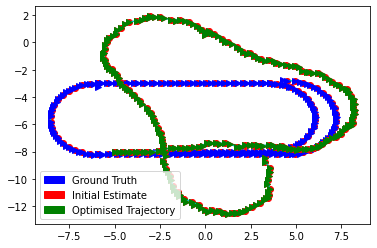

Iteration 1: Error: 16162.4287109375
Iteration 2: Error: 1186.8057861328125
Iteration 3: Error: 988.144287109375
Iteration 4: Error: 361.87347412109375
Iteration 5: Error: 163.36444091796875


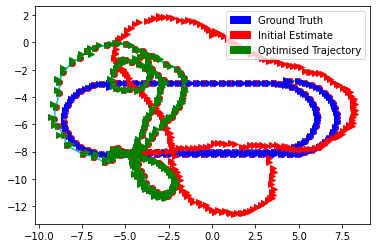

Iteration 6: Error: 835.0156860351562
Iteration 7: Error: 1250.0716552734375
Iteration 8: Error: 2406.145751953125
Iteration 9: Error: 3893.745849609375
Iteration 10: Error: 396.3664855957031


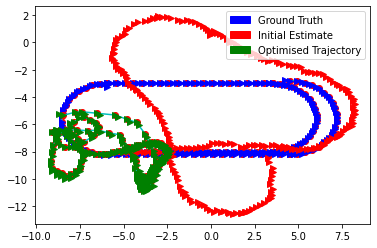

Iteration 11: Error: 44.936668395996094
Iteration 12: Error: 46.90866470336914
Iteration 13: Error: 17.45675277709961
Iteration 14: Error: 18.394006729125977
Iteration 15: Error: 20.326427459716797


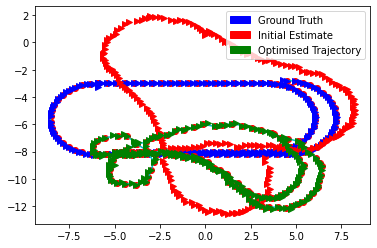

Iteration 16: Error: 22.405132293701172
Iteration 17: Error: 23.9235897064209
Iteration 18: Error: 24.835508346557617
Iteration 19: Error: 24.873153686523438
Iteration 20: Error: 24.13066291809082


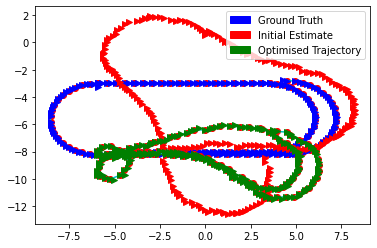

Iteration 21: Error: 20.178178787231445
Iteration 22: Error: 19.888063430786133
Iteration 23: Error: 23.442087173461914
Iteration 24: Error: 21.314416885375977
Iteration 25: Error: 18.949960708618164


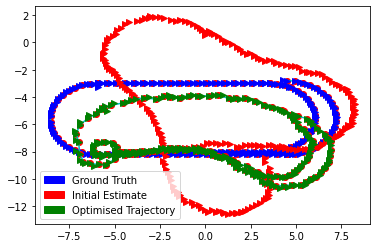

Iteration 26: Error: 17.646129608154297
Iteration 27: Error: 21.518115997314453
Iteration 28: Error: 24.924423217773438
Iteration 29: Error: 25.481122970581055
Iteration 30: Error: 22.574968338012695


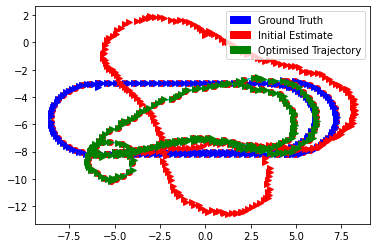

Iteration 31: Error: 20.125761032104492
Iteration 32: Error: 15.408971786499023
Iteration 33: Error: 16.499116897583008
Iteration 34: Error: 18.830669403076172
Iteration 35: Error: 16.2358455657959


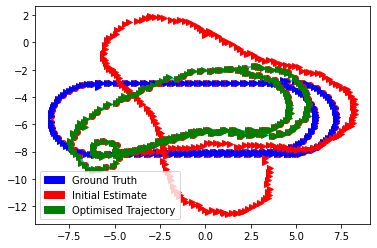

Iteration 36: Error: 14.013381958007812
Iteration 37: Error: 17.47210693359375
Iteration 38: Error: 27.09808349609375
Iteration 39: Error: 39.40748977661133
Iteration 40: Error: 46.081153869628906


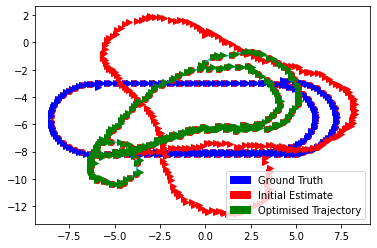

Iteration 41: Error: 37.56134033203125
Iteration 42: Error: 20.9844970703125
Iteration 43: Error: 46.73374557495117
Iteration 44: Error: 96.5043716430664
Iteration 45: Error: 73.69571685791016


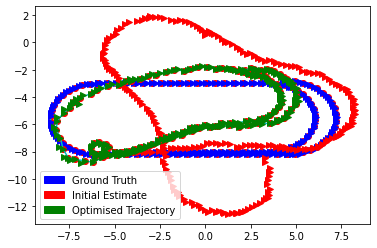

Iteration 46: Error: 28.518728256225586
Iteration 47: Error: 20.226648330688477
Iteration 48: Error: 46.54498291015625
Iteration 49: Error: 118.68818664550781
Iteration 50: Error: 263.0962219238281


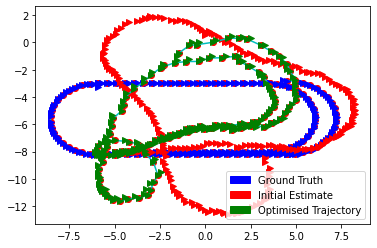

Iteration 51: Error: 499.0600891113281
Iteration 52: Error: 666.6397094726562
Iteration 53: Error: 416.3009338378906
Iteration 54: Error: 87.1964340209961
Iteration 55: Error: 45.40821838378906


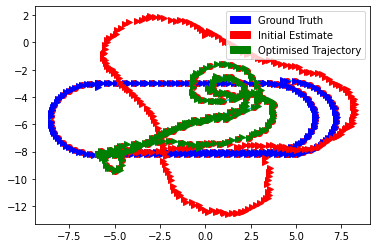

Iteration 56: Error: 45.12971878051758
Iteration 57: Error: 51.35869598388672
Iteration 58: Error: 67.7148666381836
Iteration 59: Error: 107.14501190185547
Iteration 60: Error: 197.60147094726562


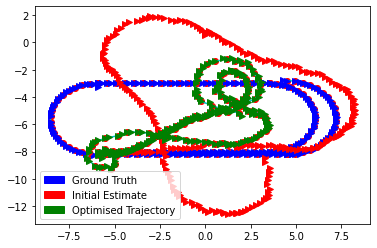

Final Error: 379.8523254394531 at itr: 61


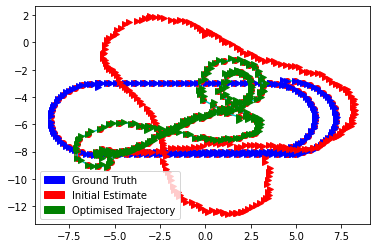

In [4]:
lm = LM(poses,edges, fixed, 0.01, 61, 1e-6, [2.5,4])
poses_arr, error_arr = lm.optimize()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.